# Day 2, Morning Session 1, MD/MC workshop
### Dr. Michael Shirts, CU Boulder

## How do we understand the information we get out of simulations?

In [1]:
# load up some modules.

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pandas as pd
%matplotlib inline

Let's load up some typical data from a simulation:

In [2]:
potential = np.loadtxt('potential.dat')

In [4]:
potential

array([-42534.128906, -42824.398438, -42978.53125 , ..., -35563.0625  ,
       -35446.75    , -35426.964844])

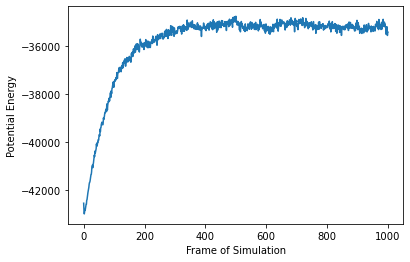

In [3]:
plt.plot(potential)
plt.xlabel("Frame of Simulation")
plt.ylabel("Potential Energy")
plt.show()


**Question: What should I report as the average potential energy of this simulation?**

In [7]:
np.mean(potential[0:])

-35841.17738512487

In [9]:
np.mean(potential[500:])

-35179.34066243115

What is the uncertainty in this average?

In [12]:
start = 50
np.std(potential[start:])/

133.75590387085327

# Reporting distributions of non-normal distributions.

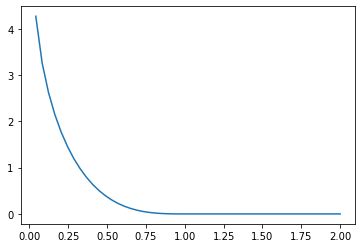

In [13]:
betaf = scipy.stats.beta(0.8,4)
x = np.linspace(0,2)
plt.plot(x,betaf.pdf(x))
plt.show()

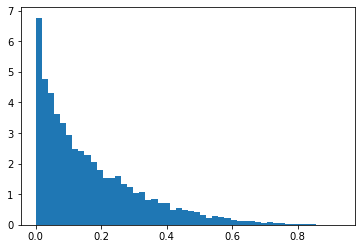

In [14]:
num = 10000
samples = betaf.rvs(num)
plt.hist(samples,bins=50,density=True)
plt.show()

### Pause and do some calculations

* What would you report as the mean and standard deviation of this distribution?
* What might be a better way to report the behavior of this distribution?

In [15]:
xlow = np.percentile(samples,2.5)
xhigh = np.percentile(samples,97.5)
print(f" 2.5% percentile is : {xlow:.4f}")
print(f"97.5% percentile is : {xhigh:.4f}")

 2.5% percentile is : 0.0025
97.5% percentile is : 0.5675


### What about the error in the mean of samples from this distribution?

In [16]:
def distribution_of_means(num,nrepeats):
    repeats = np.zeros(nrepeats)
    for i in range(nrepeats):
        repeats[i] = np.mean(betaf.rvs(num))
    return repeats

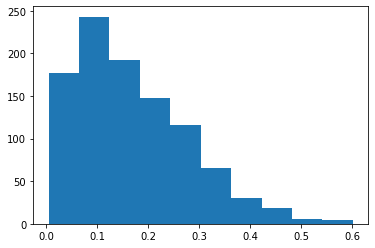

In [17]:
plt.hist(distribution_of_means(2,1000))
plt.show()

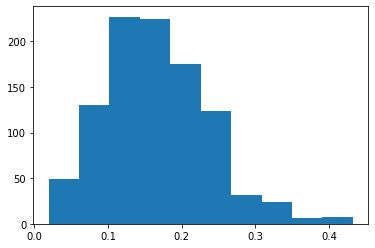

In [18]:
plt.hist(distribution_of_means(5,1000))
plt.show()

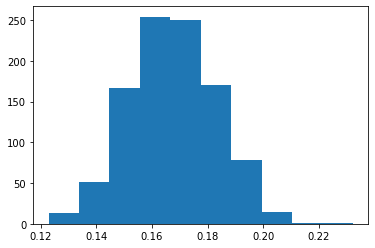

In [19]:
plt.hist(distribution_of_means(100,1000))
plt.show()

### Exercise: Is the "standard" formula good here??

In [23]:
np.std(samples)/np.sqrt(100-1)

0.015634310450823783

In [20]:
print(mean - 2*std)
print(mean + 2*std)

NameError: name 'mean' is not defined

## Determining independent points: the autocorrelation time

Important: this is only valid for a _stationary_ timeseries.

Pandas implements an autocorrelation function as a function of _lag_ ($\tau$)

In [30]:
start = 500
panda_pot = pd.Series(potential[start:]-np.mean(potential[start:]))
print(panda_pot.autocorr(0))
print(panda_pot.autocorr(100))


1.0
-0.11219125354023354


### Programming Exercises

 * Use the `autocorr` function to calculate the entire autocorrelation function for all $\tau$.  
 * Bonus points: Compute the autocorrelation function from scratch and compare.
 * Can you use your estimate the lag time $\tau$ at which the system becomes uncorrelated (i.e. the autocorrelation function) to show points spaced more than $\tau$ are independent? 
 * Note: the formulas assume that the average if the timeseries is zero, so you should subtract it off first.

In [32]:
start = 500
stationary = pd.Series(potential[start:])-np.mean(potential[start:])
n_autocorr = np.shape(stationary-1)[0]
nlim = int(n_autocorr/2)
acf = np.zeros(nlim)
for i in range(nlim):
    acf[i] = stationary.autocorr(i)

In [ ]:
gh = pd.plotting.autocorrelation_plot(panda_pot)

### When does the ACF become essentially zero?

What's your guess? Post in the notes.

### Fitting ACF to an exponential to estimate correlation time.

In [33]:
from scipy.optimize import curve_fit

In [34]:
def exponential(x, r): #function f(x, r) = e^(r*x)
    #return np.e ** (r * x)
    return np.exp(r*x) 

In [35]:
#This function calculates tau by using an exponential fit.
#To do this it uses scipy.optimize curve_fit
#curve_fit will optimize any function to fit given data

def tau_calc(ac_data, function = exponential): #takes in data and a python function
    x_data = np.arange(len(ac_data))
    pars, cov = curve_fit(f=function, xdata=x_data, ydata=ac_data, p0=[0], bounds=(-np.inf, np.inf))
    #curve fit returns an np.array of optimally fit paramters(pars) and their coverience(cov)
    #pars in this case will return an optimized value of k to fit the dataset
    return -1/pars #tau = -1/k
# scipy curve_fit documentation: https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509

In [36]:
tau = tau_calc(acf)
print(tau)

[6.26820455]


This $\tau$ is the time it takes to go from 1 to $1/e$.

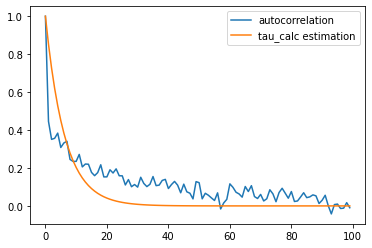

In [37]:
x_data = np.arange(100)
plt.plot(x_data,acf[0:100], label='autocorrelation') 
plt.plot(exponential(x_data, -1/tau), label = 'tau_calc estimation')
plt.legend()
plt.show()

*Key point*: If the data fits an exponential well, we can treat it as uncorrelated samples if they samples are $2\tau$ apart. 

In [53]:
start = 700
mean = np.mean(potential[start:])
print(mean)

-35194.81663986712


In [54]:
nsamples = (len(potential)-start)/(2*6.3)
#nsamples = (len(potential)-start)
stderr_mean = np.std(potential[start:])/np.sqrt(nsamples-1)

What should we use instead of `nsamples` above?

In [55]:
print(f"Mean = {mean}, sderr_mean = {stderr_mean}")

Mean = -35194.81663986712, sderr_mean = 26.726525287464483


In [52]:
-35179.34066243115

-35179.34066243115

What we are probably interested in is the average potential energy per molecule, not the total potential energy. There were 900 water molecules in the simulation above.

We can estimate the heat of vaporization $H_{vap}$ by:
    
\begin{eqnarray}
H_{vap} &=& H_{gas}-H_{liquid} \\
        &=& U_{gas} + PV_{gas} - (U_{liquid} + PV_{liquid}) \\ 
        &=& \left(U_{gas} - U_{liquid}\right) - P \left(V_{gas}-V_{liquid}\right) \\ 
\end{eqnarray}

Since the kinetic energy of liquid and vapor is the same, then this is

\begin{eqnarray}
U_{pot,gas} - U_{pot,liquid} + P(V_{gas}- V_{liquid})
\end{eqnarray}

If we assume ideality of gas ($PV=nRT$), and zero internal energy (which is valid for rigid water, like TIP3P or SPC/E), then we get:

\begin{eqnarray}
       &=& - U_{pot,liquid} + P\left( \frac{nRT}{P} - V_{liquid}\right) \\
        &=& - U_{pot,liquid} + nRT - PV_{liquid} \\
\mathrm{Molar} &=& -\frac{U_{pot,liquid}}{N} + RT - \frac{PV_{liquid}}{N}
\end{eqnarray}

### Exercises

What is the $H_{vap}$ of water predicted by this simulation? What is the uncertainty in the estimate? How does it compare to the experimental $H_{vap}$ of water is 40.7 kJ/mol?

In [56]:
print(f"Hvap = {-mean/900 + (300)*(0.00831)-(0.0821)*(0.01802)/900:.3f} +/- {stderr_mean/900:.3f}")

Hvap = 41.598 +/- 0.030


## Automated tool for equilibration detection and correlation

We can use scipy statistical tests to see if two parts of the distributions are within the uncertainties of each other.  NOTE: have to use uncorrelated samples, or it will erroneously say that they are NOT within uncertainties of each other.

A higher T-statistic means more difference between the data sets

A lower P-value indicates a low probability that the difference in means was by chance

P-value < 0.05 suggest they are two different data sets! 

### Exercise:  Use this code to estimate better than "eyeballing" what fraction is equibrated  

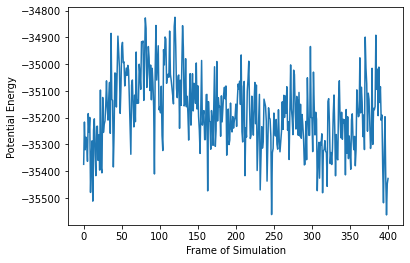

In [60]:
plt.plot(potential[600:])
plt.xlabel("Frame of Simulation")
plt.ylabel("Potential Energy")
plt.show()


In [62]:
start = 600
cut = 800
stop = 1000
per_ind_sample = 20  # the number of indices between independent samples
# compare 
scipy.stats.ttest_ind(potential[start:cut:per_ind_sample],potential[cut:stop:per_ind_sample],equal_var=True)


Ttest_indResult(statistic=1.333787248936898, pvalue=0.19890601164672067)

### Pymbar.timeseries tools 

In [64]:
from pymbar import timeseries

In [65]:
[t0, g, Neff_max] = timeseries.detectEquilibration(potential)
# t0 is the initial point detected as starting the stationary point.
# g is the estimate of the correlation time (approximately 2tau)
# Neff_max is an estimate of the _effective_ number of samples.

In [67]:
print(t0)
print(g)
print(Neff_max)

745
5.662475
45.386513


We can subsample the data, picking every $n$th particle so that all the points are statistically independent.

In [69]:
newdata = timeseries.subsampleCorrelatedData(potential[500:],g=5.66)
len(potential[500:])
len(newdata)

89

In [70]:
newdata

[0,
 6,
 11,
 17,
 23,
 28,
 34,
 40,
 45,
 51,
 57,
 62,
 68,
 74,
 79,
 85,
 91,
 96,
 102,
 108,
 113,
 119,
 125,
 130,
 136,
 142,
 147,
 153,
 158,
 164,
 170,
 175,
 181,
 187,
 192,
 198,
 204,
 209,
 215,
 221,
 226,
 232,
 238,
 243,
 249,
 255,
 260,
 266,
 272,
 277,
 283,
 289,
 294,
 300,
 306,
 311,
 317,
 323,
 328,
 334,
 340,
 345,
 351,
 357,
 362,
 368,
 374,
 379,
 385,
 391,
 396,
 402,
 408,
 413,
 419,
 424,
 430,
 436,
 441,
 447,
 453,
 458,
 464,
 470,
 475,
 481,
 487,
 492,
 498]

## Bootstrapping for complicated uncertainties.


There is a difference in statistics between a **population** and a **sample**. The population is all the possible observations out there. For instance if I were an epidemiologist, this might be all the people in the U.S. or all the children in Massachusetts.


<img width="304" height="232" alt="Image result for population versus sample" src="http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_BiostatisticsBasics/Sampling3.jpg">


But this can also be applied to measurements in the lab as well such as possible voltage values from this battery. If you ran an infinite number of experients, you would get an infinite number of measurements, but either in this case of the whole US population case: accessing the actual population is virtually impossible.

<img width="304" height="223" alt="Image result for thermometer gif" src="https://media.giphy.com/media/26FL3uMhARSAvIZZS/giphy.gif">

As a scientist, you only have access to a sample. Part of designing an experiment is choosing how big your sample should be.

But a key problem is: if you change your sample, it could change your sample mean and sample variance significantly. So the question is, how can you understand the variation in the **population** by only looking at your **sample**.

Let me repeat: the question, which the bootstrap is trying to answer, is to understand the variation in the  **population** by understanding the  variation at your **sample**.


Let's say we were in the lab, and we were making a calibration curve, say absorbance against concentration using UV-vis measurements. You generate the following plot:

In [ ]:
def generate_data(xlim=[0,5],ylim=[0,100],npoints=20,noise=1.0,seed=None,noise_model="even"):
    '''
    This function just generates some random data that might look like at UV-vis output.
    Inputs: range of data in the x and y direction, the number of points, and the level of noise.
    Add random number seed to allow repetability
    
    We have two types of noise; even noise, and the other exponential noise model.
    '''
    np.random.seed(seed) # so we can control the random noise
    x = np.linspace(xlim[0], xlim[1], npoints)
    y_raw = np.linspace(ylim[0], ylim[1], npoints)
    if noise_model == "even":
        y = y_raw + noise*np.random.rand(npoints)
    else:
        y = y_raw + np.exp(x*np.random.rand(npoints)) - 1
    return x, y 

In [ ]:
xmin = 0
xmax = 5

ymin = 0
ymax = 100

npoints = 50

# in the absence of noise, the slope is 25 and the intercept is 0, 
# but because of the heteroscedasticity, the linear fit will be somewhat biased.

x, y = generate_data(xlim=[xmin,xmax],ylim=[ymin,ymax],noise=1.0,npoints=npoints,noise_model="exponenential", seed=1)


results = stats.linregress(x,y)
slope = results.slope
intercept = results.intercept
y_fit = intercept + np.array([xmin,xmax])*slope
original_data = pd.DataFrame({'x': x, 'y':y})
original_data.head()

Now we plot the data and the fit.

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(original_data['x'], original_data['y'], alpha=0.5, label='raw data')
ax.plot(np.array([0,5]), y_fit, linewidth=4, label='linear fit')
ax.set_xlim([0, 5])
ax.set_ylim([0, 200])
ax.legend(loc="lower right")
plt.show()

But uh oh. You can see that some are those points have error getting a little large. You want to get some indication of how your calibration curve would change if you repeated the experiment again. 

Instead of actually repeating the experiment, you decide to use bootstrapping, and *estimate the variation within your sample as a replacement for the variation within your population.*

To do this, you will generate "new" samples, picking from the data **with replacement**, pretending the data you collected is **entirely representative** of the actual population) **with replacement** and perform a regression on this resampling of your sample.
**With replacement**, means you can draw the same point multiple times, is an important statement. We are assuming our population is much, much, bigger than our sample, but has the exact same distribution as our sample.  So when we withdraw the value at has x=1.456, there are still infinte more points with x=1.456 remaining. So the next point you pick is just as likely to be x=1.456 as it was the first time you drew it.

You will generate some code to do this. First, though, we will see what happens if we resample from the original population, then we will see what bootstrapping can do. 

So first, we are drawing from the _population_, because we are regenerating the entire dataset, including with new amounts of noise.

In [ ]:
def draw_from_population(data,npoints=20,ndraws=10):
    '''
    Draw from the population using the generate_data function,
    and determining the slope and intercept for each process. 
    '''
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(data['x'], data['y'], alpha=0.5, label='raw data')

    xmin = data['x'].min()
    xmax = data['x'].max()
    
    # initializing outputs
    slope = np.zeros(ndraws)
    intercept = np.zeros(ndraws)

    for i in range(ndraws):
        # vvvv - these are the lines to change for bootstrap
        #x, y = generate_data(xlim=[xmin,xmax],ylim=[ymin,ymax],npoints=npoints,noise=10.0) # don't set the seed, so we get new random data.
        x, y = generate_data(xlim=[xmin,xmax],ylim=[ymin,ymax],npoints=npoints,noise=1.0,noise_model="exponenential") # don't set the seed, so we get new random data.
        sample = pd.DataFrame({'x': x, 'y':y})
        # ^^^^ 
        results = stats.linregress(sample['x'].values,sample['y'])
        slope[i] = results.slope
        intercept[i] = results.intercept
        y_fit = intercept[i] + np.array([0,5])*slope[i]
        ax.plot(np.array([xmin,xmax]), y_fit, linewidth=2, color='b', alpha=0.2)
    return slope, intercept

In [ ]:
draw_from_population(original_data,npoints=20,ndraws=10)

We can repeat this, like, 5000 times, generate a distribution of slopes and intercepts, and use the distributions to calculate confidence intervals on the slope and intercept:

In [ ]:
slopes, intercepts = draw_from_population(original_data,npoints=50,ndraws=5000)

In [ ]:
plt.figure()
plt.hist(slopes,bins=30)
plt.title('slope values')
plt.figure()
plt.hist(intercepts,bins=30)
plt.title('intercept values')
ci = 95

print('mean slope: {:.2f} +/- {:.2f} ({:2d}% CI: {:.2f} - {:.2f})'.format(np.mean(slopes), 
                                                       np.std(slopes,ddof=1), ci,
                                                       np.percentile(slopes, ((100-ci)/2)),
                                                       np.percentile(slopes, ((100+ci)/2))))

print('mean intercept: {:.2f} +/- {:.2f} ({:2d}% CI: {:.2f} - {:.2f})'.format(np.mean(intercepts), 
                                                       np.std(intercepts,ddof=1), ci,
                                                       np.percentile(intercepts, ((100-ci)/2)),
                                                       np.percentile(intercepts, ((100+ci)/2))))


Let's see how these values compare to the ones estimated by the standard linear estimator.

In [ ]:
results = stats.linregress(original_data['x'],original_data['y'])
print(f"slope + standard error of slope = {results.slope:.2f} +/- {results.stderr:.2f}")
print(f"intercept + standard error of intercept = {results.intercept:.2f} +/- {results.intercept_stderr:.2f}")

They seem statistically consistent!  Both the constant term and the x term are within the error bars; or equivalently, the values are well within the distributions. 

### Now, to the bootstrap

To pull a sample with replacement, we will take advantage of `pandas` sampling capabilities:

In [ ]:
original_data.head()
subsample = original_data.sample(n=original_data.x.count(), replace=True)
print(subsample)

Note that some samples occur more than once, and some don't appear at all! That is what with replacement means!

**Hacking Time**: That code draws *one* bootstrap sample. Copy the `draw_from_population` function from above to create a new function `bootstrap_from_data` to plot the lines from _multiple bootstrap samples_ of the original dataset instead of multiple draws from the population.

In [ ]:
def draw_from_bootstrap(data,ndraws=500):
    '''
    Draw from the boostrap and determining the slope and intercept for each process. 
    '''
    

Note that bootstrap means will not be exactly the same as the population means, as each draw from the population will be different, and if we determine the bootstrap means more precisely, they will converge to the value for that sample, which should be well WITHIN the distribution of populations means (it will be have the distribution of the population distribution of means).  

Once you have the code working, then run the line below - you should hopefully get something similar to the draw from population!

In [ ]:
slopes_boot, intercepts_boot = draw_from_bootstrap(original_data,ndraws=5000)

**Hacking time, Part 2**: plot the histograms of the distribution of slopes and intercepts of the population and the bootstrap samples and compare. 

In [ ]:
plt.figure()
plt.hist(slopes,bins=30,alpha=0.4,density=True,label='population')
plt.hist(slopes_boot,bins=30,alpha=0.4,color='orange',density=True,label='bootstrap')
plt.legend()
plt.title('slope values')
ci = 95
print('mean slope (bootstrap): {:.2f} +/- {:.2f} ({:2d}% CI: {:.2f} - {:.2f})'.format(np.mean(slopes_boot), 
                                                       np.std(slopes_boot,ddof=1),ci,
                                                       np.percentile(slopes_boot, ((100-ci)/2)),
                                                       np.percentile(slopes_boot, ((100+ci)/2))))
plt.show()

plt.figure()
plt.hist(intercepts,bins=30,alpha=0.4,density=True,label='population')
plt.hist(intercepts_boot,bins=30,alpha=0.4,color='orange',density=True,label='bootstrap')
plt.title('intercept values')
plt.legend()
ci = 95
print('mean intercept (bootstrap): {:.2f} +/- {:.2f} ({:2d}% CI: {:.2f} - {:.2f})'.format(np.mean(intercepts_boot), 
                                                       np.std(intercepts_boot,ddof=1),ci,
                                                       np.percentile(intercepts_boot, ((100-ci)/2)),
                                                       np.percentile(intercepts_boot, ((100+ci)/2))))
plt.show()

### Bootstrapping for complicated function distributions

Bootstrapping is generalizable to any statistical quantities you may be interested in. One useful example is error propagation. If you know the error in raw datasets, and you want to know how that error will impact downstream calculations, you can use bootstrapping to do it **without having to do the calculus** involved in standard error propagation, or if the error propagation is really impossible to do. 

For example, try obtaining the distribution of the log of the absolute value of the (intercept/slope) in the linear fit above. What is the average and the distribution of this quantity? (Why this quantity? No reason, really, except that it would be REALLY HARD to get the distribution of errors using any standard error propagation). Compare this to what one would get using bootstrapping.

Similarly, bootstrapping can be used to estimate error in ANY fitting procedure extending beyond linear regression.

In [ ]:
plt.figure()
vals = np.sin(np.log(np.fabs(slopes/intercepts)))
vals_boot = np.sin(np.log(np.fabs(slopes_boot/intercepts_boot)))
plt.hist(vals,bins=30,alpha=0.4, density=True,label='population')
plt.hist(vals_boot,bins=30,alpha=0.4,density=True,color='orange',label='bootstrap')
plt.title('f(slope/intercepts) values')
plt.legend()
ci = 95

print('mean sin(log(abs(slope/intercept))): {:.2f} ({:2d}% CI: {:.2f} - {:.2f})'.format(np.mean(vals), ci,
                                                       np.percentile(vals, ((100-ci)/2)),
                                                       np.percentile(vals, ((100+ci)/2))))
print('mean sin(log(abs(slope/intercept))): (Bootstrap): {:.2f} ({:2d}% CI: {:.2f} - {:.2f})'.format(np.mean(vals_boot), ci,
                                                       np.percentile(vals_boot, ((100-ci)/2)),
                                                       np.percentile(vals_boot, ((100+ci)/2))))